# 04 - Clustering

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import os
import matplotlib.animation as animation

from models.BRUTAL_X_RCC import XRCC#, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
from IPython.display import display

In [2]:
# -- FREE PARAMETERS
n_seasons   = 2
n_iters     = 300

learning_rate   = 5
min_len         = 10
mode            = 'single'
starting_bp     = [50, 330]

overwrite_results = True

In [3]:
# Geopackages with boundaries
country_boundary_file   = '../data/preprocessed/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/preprocessed/external/GADM41_WORLD_clip.gpkg' 
hkkh_boundary_file      = '../data/preprocessed/external/HKKH.gpkg'

# Path for results
results_path_file   = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.nc'
results_path_image  = f'../data/results/images/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.png'

if os.path.exists(results_path_file) and overwrite_results:
    results_exist = True
    print('Results already stored! - Overwriting')

if os.path.exists(results_path_file) and not overwrite_results:
    results_exist = True
    print('Results already stored! - Skipping clustering')

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file)
hkkh_boundary       = gpd.read_file(hkkh_boundary_file)

In [4]:
if not os.path.exists(results_path_file) or overwrite_results:

    dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load()
    dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load()
    dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load()
    dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load()

    dataset_tp['time'] = dataset_t2m['time']
    dataset_u100['time'] = dataset_t2m['time']
    dataset_v100['time'] = dataset_t2m['time']

    datasets = [dataset_tp, dataset_t2m, dataset_u100, dataset_v100]  # Add as many datasets as needed

    clustering_params = {
        'iters': n_iters,
        'n_seas': n_seasons,
        'learning_rate': learning_rate,
        'min_len': min_len,
        'mode': mode,
        'starting_bp': starting_bp,
    }

    breakpoints, error_history_da, silhouette_scores_da = XRCC(datasets, **clustering_params)

else:
    result = xr.open_dataset(results_path_file).__xarray_dataarray_variable__

300it [00:00, 749.08it/s]
300it [00:00, 783.21it/s]
300it [00:00, 786.71it/s]
300it [00:00, 787.46it/s]
300it [00:00, 787.10it/s]
300it [00:00, 595.72it/s]
300it [00:00, 794.72it/s]
300it [00:00, 797.01it/s]
300it [00:00, 793.47it/s]
300it [00:00, 793.86it/s]
300it [00:00, 792.94it/s]
300it [00:00, 794.33it/s]
300it [00:00, 791.55it/s]
300it [00:00, 791.65it/s]
300it [00:00, 791.86it/s]
300it [00:00, 792.84it/s]
300it [00:00, 791.09it/s]
300it [00:00, 801.66it/s]
300it [00:00, 797.60it/s]
300it [00:00, 797.16it/s]
300it [00:00, 795.70it/s]
300it [00:00, 784.84it/s]
300it [00:00, 796.15it/s]
300it [00:00, 795.24it/s]
300it [00:00, 795.49it/s]
300it [00:00, 798.21it/s]
300it [00:00, 795.71it/s]
300it [00:00, 797.01it/s]
300it [00:00, 792.83it/s]
300it [00:00, 795.65it/s]
300it [00:00, 796.36it/s]
300it [00:00, 792.57it/s]
300it [00:00, 794.33it/s]
300it [00:00, 800.49it/s]
300it [00:00, 791.74it/s]
300it [00:00, 796.68it/s]
300it [00:00, 796.44it/s]
300it [00:00, 795.84it/s]
300it [00:00

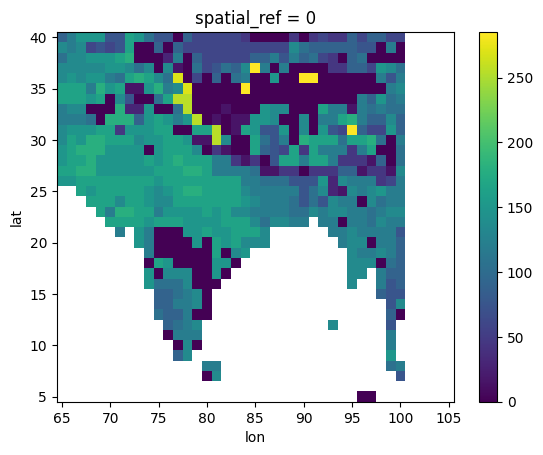

In [5]:
breakpoints.sel(cluster=0).plot()

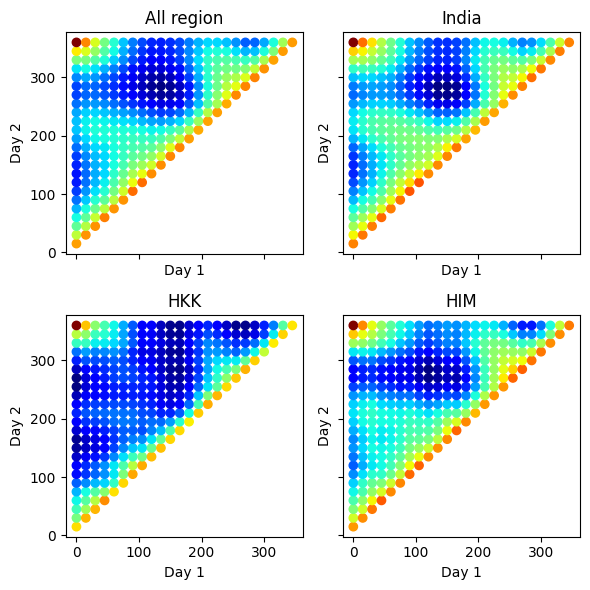

In [6]:
from itertools import combinations

n_days = list(np.arange(0,365,15))

x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]


# Load country boundary data
error_history_da_clip = error_history_da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
error_history_da_clip.rio.write_crs("epsg:4326", inplace=True)


error_history_da_clip_IND = error_history_da_clip.rio.clip(country_boundary.geometry.apply(mapping), country_boundary.crs, drop=True)
error_history_da_clip_HKK = error_history_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='hkk'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='hkk'].crs, drop=True)
error_history_da_clip_HIM = error_history_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='him'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='him'].crs, drop=True)

z_all = error_history_da_clip.mean(['lat', 'lon']).values
z_IND = error_history_da_clip_IND.mean(['lat', 'lon']).values
z_HKK = error_history_da_clip_HKK.mean(['lat', 'lon']).values
z_HIM = error_history_da_clip_HIM.mean(['lat', 'lon']).values


fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True, sharey=True)
ax[0][0].scatter(x, y, c=z_all, cmap='jet')
ax[0][0].set_title('All region')
ax[0][0].set_xlabel('Day 1')
ax[0][0].set_ylabel('Day 2')

ax[0][1].scatter(x, y, c=z_IND, cmap='jet')
ax[0][1].set_title('India')
ax[0][1].set_xlabel('Day 1')
ax[0][1].set_ylabel('Day 2')

ax[1][0].scatter(x, y, c=z_HKK, cmap='jet')
ax[1][0].set_title('HKK')
ax[1][0].set_xlabel('Day 1')
ax[1][0].set_ylabel('Day 2')

ax[1][1].scatter(x, y, c=z_HIM, cmap='jet')
ax[1][1].set_title('HIM')
ax[1][1].set_xlabel('Day 1')
ax[1][1].set_ylabel('Day 2')

plt.tight_layout()


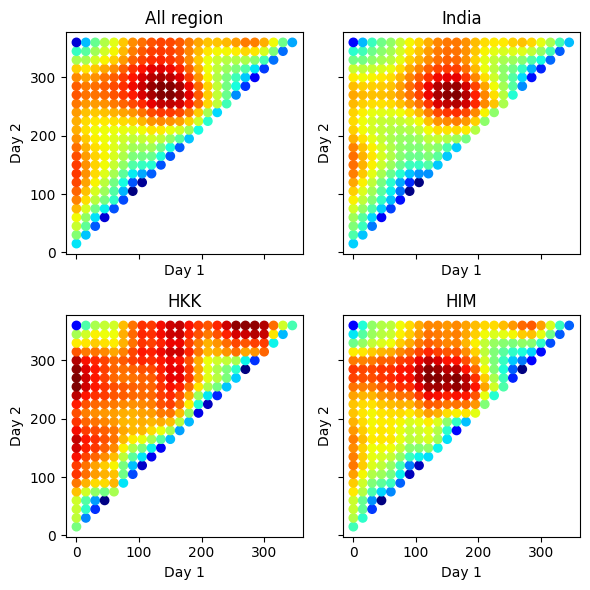

In [7]:
# Load country boundary data
silhouette_scores_da_clip = silhouette_scores_da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
silhouette_scores_da_clip.rio.write_crs("epsg:4326", inplace=True)


silhouette_scores_da_clip_IND = silhouette_scores_da_clip.rio.clip(country_boundary.geometry.apply(mapping), country_boundary.crs, drop=True)
silhouette_scores_da_clip_HKK = silhouette_scores_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='hkk'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='hkk'].crs, drop=True)
silhouette_scores_da_clip_HIM = silhouette_scores_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='him'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='him'].crs, drop=True)

z_all = silhouette_scores_da_clip.mean(['lat', 'lon']).values
z_IND = silhouette_scores_da_clip_IND.mean(['lat', 'lon']).values
z_HKK = silhouette_scores_da_clip_HKK.mean(['lat', 'lon']).values
z_HIM = silhouette_scores_da_clip_HIM.mean(['lat', 'lon']).values


fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True, sharey=True)
ax[0][0].scatter(x, y, c=z_all, cmap='jet')
ax[0][0].set_title('All region')
ax[0][0].set_xlabel('Day 1')
ax[0][0].set_ylabel('Day 2')

ax[0][1].scatter(x, y, c=z_IND, cmap='jet')
ax[0][1].set_title('India')
ax[0][1].set_xlabel('Day 1')
ax[0][1].set_ylabel('Day 2')

ax[1][0].scatter(x, y, c=z_HKK, cmap='jet')
ax[1][0].set_title('HKK')
ax[1][0].set_xlabel('Day 1')
ax[1][0].set_ylabel('Day 2')

ax[1][1].scatter(x, y, c=z_HIM, cmap='jet')
ax[1][1].set_title('HIM')
ax[1][1].set_xlabel('Day 1')
ax[1][1].set_ylabel('Day 2')

plt.tight_layout()


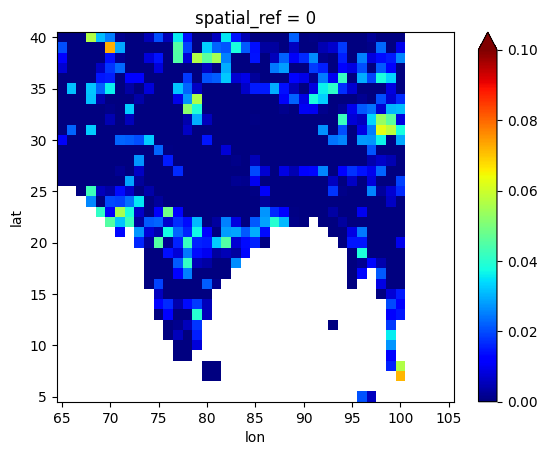

In [8]:
(silhouette_scores_da.isel(iter = -1) - silhouette_scores_da.isel(iter = 0)).plot(vmin=0, vmax=0.1, extend='max', cmap='jet')

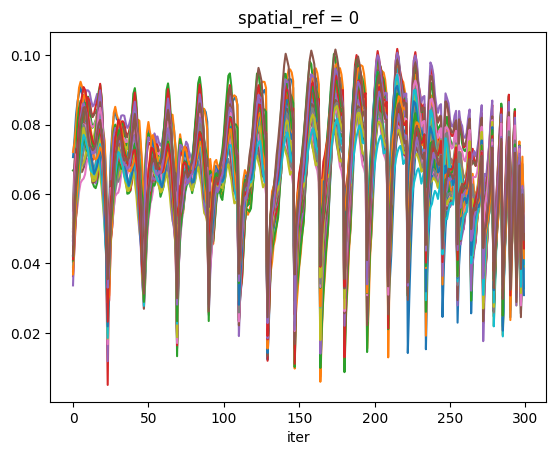

In [9]:
silhouette_scores_da.mean('lat').plot(hue='lon', add_legend=False)

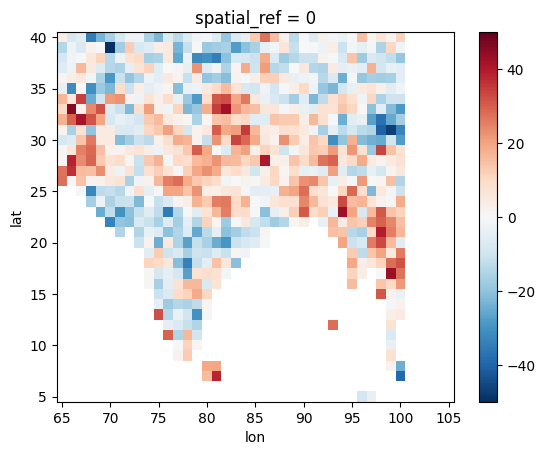

In [10]:
(error_history_da.isel(iter = -1) - error_history_da.isel(iter = 0)).plot()

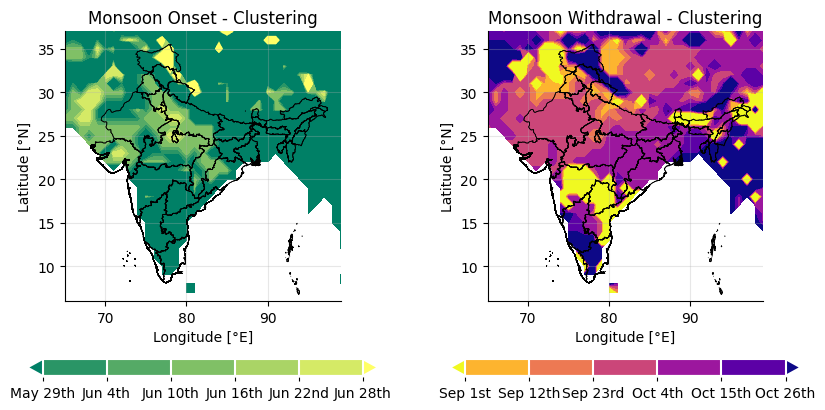

In [11]:
# Load country boundary data
# mask_boundary = gpd.read_file(world_boundary_file, layer='ADM_1')
# mask_boundary = mask_boundary[mask_boundary["GID_0"].isin(['IND','NPL','BGD'])]

# result_plot = result.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
# result_plot.rio.write_crs("epsg:4326", inplace=True)
# result_plot = result_plot.rio.clip(mask_boundary.geometry.apply(mapping), mask_boundary.crs, drop=True)

result_plot = breakpoints


plot_seasons_bk_results( result_plot, figsize=(10,5), cmaps=['summer', 'plasma_r'],
                         lims=[[150,180],[245,300]], titles=['Monsoon Onset - Clustering', 'Monsoon Withdrawal - Clustering'],
                         country_boundary=country_boundary, world_boundary=country_boundary)

# plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)

In [12]:
# if not os.path.exists(results_path_file) or overwrite_results:
    
#     result.attrs=dict(
#             Description="Dataset with seasonal onset dates obtained with Radially Constrained Clustering",
#             Parameters=(

#                 f"Number of seasons: {n_seasons}",
#                 f"Number of iterations: {n_iters}",
#                 f"Learning rate: {learning_rate}",
#                 f"Minimum length of seasons: {min_len}",
#                 f"Clustering mode: {mode}",
#                 f"Initializtion dates: {[day_of_year_to_date(x) for x in starting_bp]}",
        
#             )
#         )

#     result.to_netcdf(results_path_file)